In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from glob import glob
from tensorflow.keras.preprocessing import image

In [2]:
#Kütüphanelerin yüklenmesi
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from glob import glob
from tensorflow.keras.preprocessing import image

In [3]:
#Data setlerinin yüklenmesi
train_data = '../input/fruits/fruits-360-original-size/fruits-360-original-size/Training'
test_data =  '../input/fruits/fruits-360-original-size/fruits-360-original-size/Test'
val_data =   '../input/fruits/fruits-360-original-size/fruits-360-original-size/Validation'

In [4]:
#VGG16 Modelinin yüklenmesi ve parametlerinin girilmesi
conv = tf.keras.applications.VGG16(weights='imagenet',
                                  include_top=False,
                                  input_shape=(224,224,3),
                                  classifier_activation="softmax")

2022-01-25 19:42:15.589319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 19:42:15.697539: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 19:42:15.698218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 19:42:15.699259: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


In [5]:
#Model parametreleri
conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
#Burada sadece kullanacağımız parametreyi seçiyoruz ve diğerlerini iptal ediyoruz. Çünkü model eğitiminde '21,156,208' parametrenin işlenmesine gerek duymuyoruz.
conv.trainable=True
set_trainable=False
for layer in conv.layers:
        if layer.name == 'block5_conv3':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

In [7]:
model = tf.keras.models.Sequential() #Model Oluşturma
model.add(conv) ##Model katmanına özellik çıkaran modelimizi ekliyoruz
model.add(tf.keras.layers.Flatten()) ##Modelimizi vektör'de düzleştirme yapıyoruz
model.add(tf.keras.layers.Dense(256,activation='relu'))#Modelemiz katmanının sonuna 256 nöron ekleyip 24'lü sınıflandırma giriyoruz
model.add(tf.keras.layers.Dense(24,activation='softmax'))
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])# Yarattığımız modele eklediklerimizi sonlandırıyor ve modelimizi bitiyoryuz.
model.summary()#1. Katmanımız özellik çıkaran katmanımız
               #2. katman düzleştirme katmanımız
               #3. 256 nöron
               #4. katman sınıflandırma katmanı

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 24)                6168      
Total params: 21,143,640
Trainable params: 8,788,760
Non-trainable params: 12,354,880
_________________________________________________________________


In [8]:
#Keras görüntü ön işleme modülünü import ediyor ve parametrelerini giriyoruz
from keras.applications.vgg16 import preprocess_input
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255, # piksel değerleri 0-255'den 0-1 arasına getiriyoruz
      rotation_range=20,#Görüntüleri -20,20 arasında döndürme işlemi yapıyoruz
      width_shift_range=0.2,#kaydırma işlemi
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,#yakınlaştırma
      horizontal_flip=True,#Aynalama işlemi
      preprocessing_function=preprocess_input
      )

In [9]:
train_generator = train_datagen.flow_from_directory(
        train_data,
        target_size=(224, 224),
        batch_size=128, #128 parçalar halinde görüntüleri okumak için kullanıyoruz
        )

Found 6231 images belonging to 24 classes.


In [10]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=preprocess_input)

In [11]:
validation_generator = validation_datagen.flow_from_directory(
        val_data,
        target_size=(224, 224),
        batch_size=128,
        )

Found 3114 images belonging to 24 classes.


In [12]:
hist = model.fit_generator(train_generator,
                           steps_per_epoch= 6231 // 128,
                           epochs=5,
                           validation_data=validation_generator,
                           validation_steps= 3114 // 128)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-01-25 19:42:24.429966: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-01-25 19:42:28.056253: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


48/48 [==============================] - 170s 3s/step - loss: 1.6630 - accuracy: 0.5697 - val_loss: 0.3052 - val_accuracy: 0.8662
Epoch 2/5
48/48 [==============================] - 112s 2s/step - loss: 0.2027 - accuracy: 0.9313 - val_loss: 0.1985 - val_accuracy: 0.9154
Epoch 3/5
48/48 [==============================] - 113s 2s/step - loss: 0.1222 - accuracy: 0.9569 - val_loss: 0.3083 - val_accuracy: 0.8753
Epoch 4/5
48/48 [==============================] - 112s 2s/step - loss: 0.0711 - accuracy: 0.9738 - val_loss: 0.0510 - val_accuracy: 0.9808
Epoch 5/5
48/48 [==============================] - 113s 2s/step - loss: 0.0588 - accuracy: 0.9805 - val_loss: 0.0544 - val_accuracy: 0.9840


In [13]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


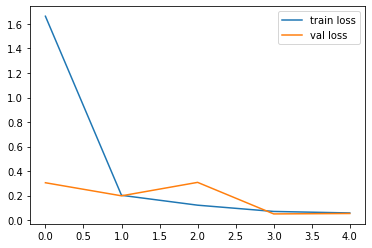

In [14]:
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()


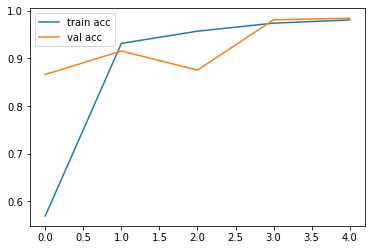

In [15]:
plt.plot(hist.history['accuracy'], label='train acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


In [16]:
model.save('trained_tf_model.h5')

In [17]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=preprocess_input
        )

In [18]:
test_generator = test_datagen.flow_from_directory(
        test_data,
        target_size=(224, 224),
        batch_size=16,
        )

Found 3110 images belonging to 24 classes.


In [19]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=3110//16)
print('test acc:', test_acc)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test acc: 0.9826030731201172
